<a href="https://colab.research.google.com/github/ce3tnia/DeepLearning/blob/master/CNN_AudioCatsAndDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install python_speech_features

In [ ]:
import os
import librosa
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from python_speech_features import mfcc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential
from sklearn.metrics import roc_curve, auc

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/catsdogs/train_test_split.csv')
df.head()

,Unnamed: 0,test_cat,test_dog,train_cat,train_dog
0,0,cat_22.wav,dog_barking_97.wav,cat_99.wav,dog_barking_33.wav
1,1,cat_116.wav,dog_barking_0.wav,cat_54.wav,dog_barking_86.wav
2,2,cat_155.wav,dog_barking_93.wav,cat_34.wav,dog_barking_45.wav
3,3,cat_58.wav,dog_barking_10.wav,cat_132.wav,dog_barking_76.wav
4,4,cat_77.wav,dog_barking_26.wav,cat_124.wav,dog_barking_4.wav


In [ ]:
#making training, test separate dfs
cat_train = df[['train_cat']].dropna().rename(index=str, columns={"train_cat":"file"}).assign(label='cat')

dog_train = df[['train_dog']].dropna().rename(index=str, columns={"train_dog":"file"}).assign(label='dog')

cat_test = df[['test_cat']].dropna().rename(index=str, columns={"test_cat":"file"}).assign(label='cat')

dog_test = df[['test_dog']].dropna().rename(index=str, columns={"test_dog":"file"}).assign(label='dog')

## concatenate all
train_df = pd.concat([cat_train, dog_train]).reset_index(drop=True)
test_df = pd.concat([cat_test, dog_test]).reset_index(drop=True)

In [ ]:
df = pd.concat([train_df, test_df]).reset_index(drop=True)
df

,file,label
0,cat_99.wav,cat
1,cat_54.wav,cat
2,cat_34.wav,cat
3,cat_132.wav,cat
4,cat_124.wav,cat
...,...,...
272,dog_barking_109.wav,dog
273,dog_barking_69.wav,dog
274,dog_barking_77.wav,dog
275,dog_barking_60.wav,dog


In [ ]:
# Loading data
path = '/content/drive/MyDrive/dataset/catsdogs/cats_dogs/'
audio_data = list()
for i in tqdm(range(df.shape[0])):
    audio_data.append(librosa.load(path+df['file'].iloc[i]))
audio_data = np.array(audio_data)

100%|██████████| 277/277 [00:41<00:00,  6.73it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
# Put the loaded data into data frame
df['audio_waves'] = audio_data[:,0]
df['samplerate'] = audio_data[:,1]
df.head()

,file,label,audio_waves,samplerate
0,cat_99.wav,cat,"[-0.07119886, -0.06775932, -0.029129358, 0.005...",22050
1,cat_54.wav,cat,"[0.013862704, 0.017383214, 0.0155879175, 0.015...",22050
2,cat_34.wav,cat,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050
3,cat_132.wav,cat,"[0.0076420866, 0.00998313, 0.009568622, 0.0091...",22050
4,cat_124.wav,cat,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050


In [ ]:
# Calculate the length of each audio file
bit_lengths = list()
for i in range(df.shape[0]):
    bit_lengths.append(len(df['audio_waves'].iloc[i]))
bit_lengths = np.array(bit_lengths)
df['bit_lengths'] = bit_lengths
df['second_lengths'] = df['bit_lengths']/df['samplerate']
df.head()

,file,label,audio_waves,samplerate,bit_lengths,second_lengths
0,cat_99.wav,cat,"[-0.07119886, -0.06775932, -0.029129358, 0.005...",22050,264600,12
1,cat_54.wav,cat,"[0.013862704, 0.017383214, 0.0155879175, 0.015...",22050,23914,1.08454
2,cat_34.wav,cat,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,192894,8.74803
3,cat_132.wav,cat,"[0.0076420866, 0.00998313, 0.009568622, 0.0091...",22050,334984,15.192
4,cat_124.wav,cat,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,23814,1.08


In [ ]:
#### Step 2: Data generation

# Take only the audio with >= 2 seconds audio length
df = df[df['second_lengths'] >= 2.0]

In [ ]:
# In case you want to create a checkpoint
with open('audio_df.pickle', 'wb') as f:
    pickle.dump(df, f)

In [ ]:
# In case you want to load a checkpoint
with open('audio_df.pickle', 'rb') as f:
    df = pickle.load(f)

In [ ]:
# Check whether our minimum length is 2 seconds or more
min_bits = np.min(df['bit_lengths'])
print(min_bits)
min_seconds = np.min(df['second_lengths'])
print(min_seconds)

44365
2.012018140589569


In [ ]:
df.shape

(229, 6)

In [ ]:
# Generate data
num_samples = 300
generated_audio_waves = list()
generated_audio_labels = list()
for i in tqdm(range(num_samples)):
    try:
        chosen_file = np.random.choice(df['file'].values)
        chosen_initial = np.random.choice(np.arange(0,df[df['file']==chosen_file]['bit_lengths'].values-min_bits))
        generated_audio_waves.append(df[df['file']==chosen_file]['audio_waves'].values[0][chosen_initial:chosen_initial+min_bits])
        
        generated_audio_labels.append(df[df['file']==chosen_file]['label'].values)
    except ValueError:
        continue
generated_audio_waves = np.array(generated_audio_waves)
generated_audio_labels = np.array(generated_audio_labels)

100%|██████████| 300/300 [00:00<00:00, 510.61it/s]


In [ ]:
#### Step 3: Features preprocessing
mfcc_features = list()
for i in tqdm(range(len(generated_audio_waves))):
    mfcc_features.append(mfcc(generated_audio_waves[i]))
mfcc_features = np.array(mfcc_features)

100%|██████████| 298/298 [00:02<00:00, 101.22it/s]


In [ ]:
# Check the shape of raw wave and MFCC features
print(generated_audio_waves.shape)
print(mfcc_features.shape)

(298, 44365)
(298, 276, 13)


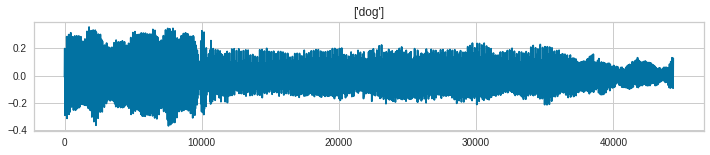

In [ ]:
# Print a raw audio wave
plt.figure(figsize=(12,2))
plt.plot(generated_audio_waves[30])
plt.title(generated_audio_labels[30])
plt.show()

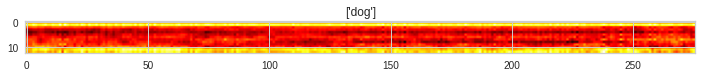

In [ ]:
# Print the MFCC features of the audio wave
plt.figure(figsize=(12, 2))
plt.imshow(mfcc_features[30].T, cmap='hot')
plt.title(generated_audio_labels[30])
plt.show()

In [ ]:
#### Step 4: Label preprocessing
# Label encoding
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(generated_audio_labels)
print(label_encoded)

[1 1 1 0 0 0 1 0 1 1 1 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0 0 0 1 1 1 1 0 1 0 1
 1 1 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 0 0 0 1 1
 0 0 1 1 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 1 0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0
 1 0 1 0 1 1 1 1 0 0 1 0 1 0 1 1 0 1 1 0 0 0 0 0 0 1 1 0 0 1 0 1 1 1 1 1 0
 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0
 1 0 0 0 0 0 1 1 1 0 1 0 1 1 1 0 0 0 0 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 0
 1 0]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
label_encoded = label_encoded[:, np.newaxis]
print(label_encoded)

[[1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]


In [ ]:
# One hot encoding
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(label_encoded)
print(one_hot_encoded)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 

In [ ]:
#### Step 5: Model training
X = mfcc_features
y = one_hot_encoded
X = (X-X.min())/(X.max()-X.min())

In [ ]:
# Train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [ ]:
# Defining input shape for the neural network
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [ ]:
# Reshape X_train and X_test such that they are having the same shape as the input shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print(X_test.shape)

(208, 276, 13, 1)
(90, 276, 13, 1)


In [ ]:
# Constructing the neural network architecture
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=input_shape))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 276, 13, 16)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 138, 6, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 138, 6, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 69, 3, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 69, 3, 64)         18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 34, 1, 64)         0         
_________________________________________________________________
dropout (Dropout)            (None, 34, 1, 64)         0

Epoch 1/50
7/7 [==============================] - 17s 215ms/step - loss: 0.7052 - acc: 0.4901 - val_loss: 0.6886 - val_acc: 0.5000
Epoch 2/50
7/7 [==============================] - 1s 104ms/step - loss: 0.7048 - acc: 0.4335 - val_loss: 0.6887 - val_acc: 0.5000
Epoch 3/50
7/7 [==============================] - 1s 103ms/step - loss: 0.6941 - acc: 0.5333 - val_loss: 0.6853 - val_acc: 0.5000
Epoch 4/50
7/7 [==============================] - 1s 102ms/step - loss: 0.6934 - acc: 0.4856 - val_loss: 0.6766 - val_acc: 0.5000
Epoch 5/50
7/7 [==============================] - 1s 101ms/step - loss: 0.6797 - acc: 0.5646 - val_loss: 0.6565 - val_acc: 0.5222
Epoch 6/50
7/7 [==============================] - 1s 102ms/step - loss: 0.6721 - acc: 0.6234 - val_loss: 0.6241 - val_acc: 0.7333
Epoch 7/50
7/7 [==============================] - 1s 106ms/step - loss: 0.6454 - acc: 0.6611 - val_loss: 0.5814 - val_acc: 0.8444
Epoch 8/50
7/7 [==============================] - 1s 103ms/step - loss: 0.5878 - acc: 0.7

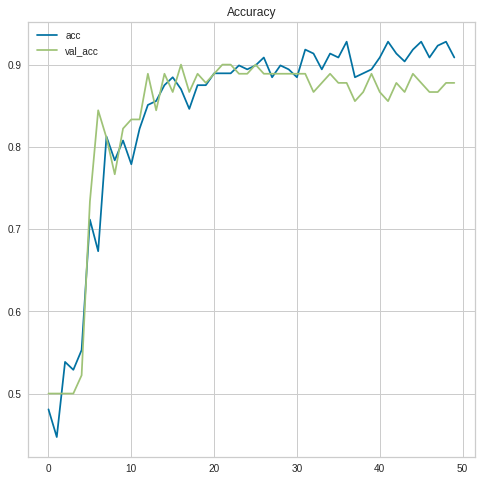

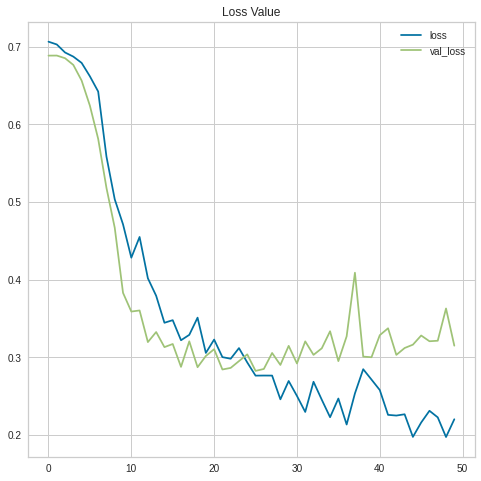

In [ ]:
# Training the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

plt.figure(figsize=(8,8))
plt.title('Accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.show()

# Displaying loss values
plt.figure(figsize=(8,8))
plt.title('Loss Value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
prediction = model.predict(X_test)

In [ ]:
predictions = np.argmax(prediction, axis=1)
y_test = one_hot_encoder.inverse_transform(y_test)

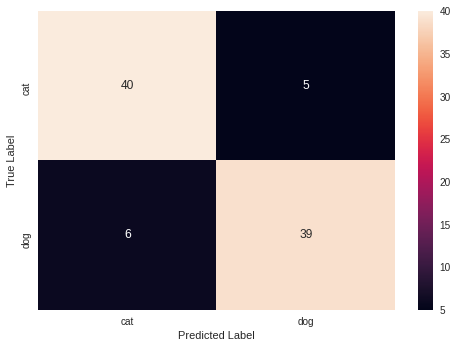

In [ ]:
cm = confusion_matrix(y_test, predictions)
ax = plt.subplot()
sns.heatmap(cm, annot=True, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, fmt='d', cbar=True, ax=ax)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

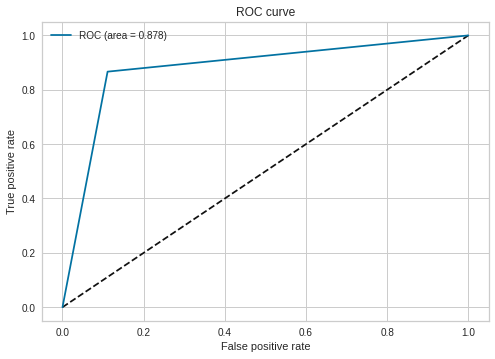

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test.ravel(), predictions.ravel())
auc_ = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC (area = {:.3f})'.format(auc_))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
print('Classification Report \n{}'.format(classification_report(y_test, model.predict_classes(X_test))))

Classification Report 
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        45
           1       0.89      0.87      0.88        45

    accuracy                           0.88        90
   macro avg       0.88      0.88      0.88        90
weighted avg       0.88      0.88      0.88        90



/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
print(input_shape)

(276, 13, 1)


In [ ]:
len(X_test), len(y_test), len(X_train), len(y_train)

(90, 90, 208, 208)

In [ ]:
print("in X_train, there is {} cats and {} dogs".format(len(y_train) - sum(y_train), sum(y_train)))
print("in X_test, there is {} cats and {} dogs".format(len(y_test) - sum(y_test), sum(y_test)))

print (y_test.shape)

in X_train, there is [103. 105.] cats and [105. 103.] dogs
in X_test, there is [45] cats and [45] dogs
(90, 1)
